In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
N_SAMPLES = 1000
noise = torch.randn(N_SAMPLES) * 3
# Pick the values of the parameters we want to learn
param_1_actual = 8.765
param_2_actual = -4.321

def f(xs, param1=param_1_actual, param2=param_2_actual, add_noise=True):
    """
    This function generates Ys from xs. xs should be a torch.tensor with two columns.
    The default for param1 and param2 are given, but we may want to change them later.
    By default, we'll add noise but we'll see some other visualizations are 
    cleaner when we remove it.
    """
    params = torch.tensor([param1, param2]).float()
    out = xs@params
    if add_noise:
        out.add_(torch.randn(xs.shape[0]) * 3)
    return out

In [3]:
# Create the xs
xs = torch.randn(N_SAMPLES, 2)

In [4]:
# Create the ys
ys = f(xs)

# Exercise 6.1: Make a dataset

Use what you know from previous lessions to complete the class `MyDataset`.
Then, use the `xs` and `ys` we created to instantiate your dataset and a `DataLoader` with `batch_size=32` and `shuffle=True`.
<!-- startquestion -->

In [7]:
# Use what you know from previous lessions to complete the class `MyDataset`.
# Then, use the `xs` and `ys` we created to instantiate your dataset and a `DataLoader` with `batch_size=32` and `shuffle=True`.

class MyDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

# Create the datset
ds = MyDataset(xs, ys)
# Create the dataloader
dl = DataLoader(ds, batch_size=32, shuffle=True)

In [8]:
assert isinstance(ds, Dataset)
assert isinstance(dl, DataLoader)

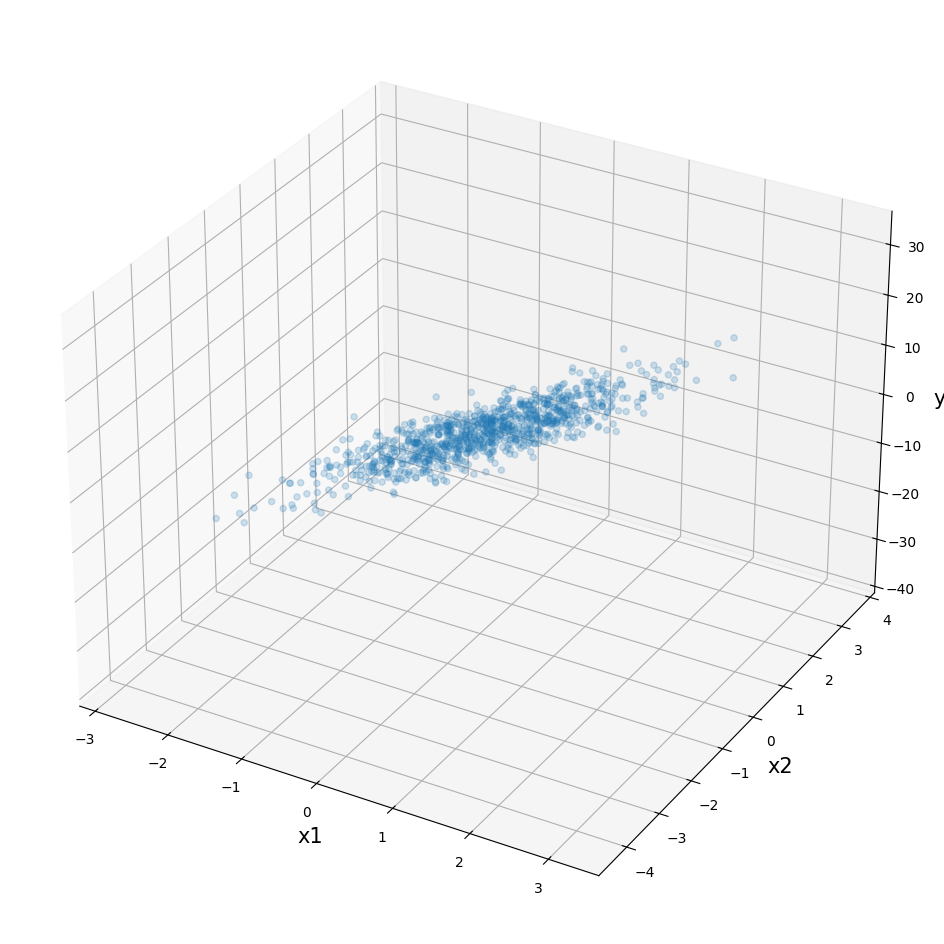

In [9]:
# Visualize a sample of our data
_df = pd.DataFrame(xs.numpy(), columns=['x1', 'x2'])
_df['y'] = ys.numpy()
data_fig = plt.figure(figsize=(12,12))
ax = data_fig.add_subplot(projection='3d')
ax.scatter(_df.x1, _df.x2, _df.y, alpha=0.2)
ax.set_xlabel('x1', fontsize=15)
ax.set_ylabel('x2', fontsize=15)
ax.set_zlabel('y', fontsize=15)
plt.close()
data_fig

# Exercise 6.2: Create a small neural network

Please complete the class `Net` by completing the `__init__` and `forward` methods.
Your parameters should contain a float tensor with two elements, one for $x_1$ and one for $x_2$.
Please initialize each of those parameters to the value 3.0.
The `forward` method should multiply your inputs by these parameters.
In this case, let's ignore the bias parameter, since we didn't use it in creating our dataset.

<!-- startquestion -->

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize parameters as a float tensor with two elements, both set to 3.0
        self.params = nn.Parameter(torch.tensor([3.0, 3.0]))

    def forward(self, x):
        # Multiply inputs by the parameters
        return x * self.params

In [14]:
assert Net()(torch.tensor([[1., 1.]])) == 6 # Check the outputs against a known input
assert (next(Net().parameters()).data == torch.tensor([3., 3.])).all() # Check that the parameters are all 3

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [15]:
def get_parameters_over_training(optimizer, opt_kwargs={'lr':1e-3}):
    """
    This function is used to learn about different optimizers.
    The optimizer argument is a class from torch.optim,
    and the opt_kwargs is a dictionary of keyword arguments to pass
    to the optimizer as it's instantiated.

    This function returns a tuple of (params_history, losses)
    where params_history is a numpy array where each column represents
    the history of a parameter as the model's trained.
    The losses are just the loss at every step.
    """
    # Instantiate our network
    model = Net()
    # Instantiate the optimizer
    opt = optimizer(model.parameters(), **opt_kwargs)
    # Create placeholders for the params history and losses
    params_history = []
    losses = []
    # Instantiate the loss
    loss = nn.MSELoss()
    # Train the model for 50 epochs
    for epoch in range(50):
        for x_b, y_b in ds:
            # Make predictions
            preds = model(x_b)
            # Log the parameters
            c = model.params.clone().detach().numpy()
            params_history.append(c)
            # Calculate and record the loss
            l = loss(preds, y_b)
            losses.append(l.clone().detach().numpy())
            # Calculate the gradients
            l.backward()
            # Apply the optimizer update and zero the gradients
            opt.step()
            opt.zero_grad()
        if epoch % 10 == 0:
            print(l.detach().numpy(), c)
    return np.vstack(params_history), np.hstack(losses)

In [16]:
def loss_fig(smooth=True):
    """
    Plots a contour map of the loss.
    If smooth = True, the landscape will look like nice circles.
    While this is a nicer visualization, the actual loss landscape
    is hinted at when smooth = False.

    Returns a pyplot.Figure
    """
    p1r = np.linspace(2, 10)
    p2r = np.linspace(4, -10)
    X, Y = np.meshgrid(p1r, p2r)
    Z = np.zeros_like(X)
    rows, cols = X.shape
    for i in range(rows):
        for j in range(cols):
            preds = f(xs, X[i,j], Y[i,j], add_noise=not smooth)
            Z[i,j] = float(nn.MSELoss()(preds, ys).numpy())
    fig, ax = plt.subplots(figsize=(12, 12))
    CS = ax.contour(X, Y, Z, levels=[.1, 1, 2, 4, 8, 16, 32, 64], colors='k')
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_xlabel('Param 1')
    ax.set_ylabel('Param 2')
    plt.close()
    return fig

def plot_losses(losses, n_steps=None):
    """
    Plots a list of losses, assuming it's MSE loss.
    Returns a plt.Figure.
    """
    if n_steps:
        ls = pd.Series(losses[n_steps])
    else:
        ls = pd.Series(losses)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(ls, label='MSE')
    ax.plot(ls.rolling(100).mean(), label='MSE rolling mean')
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean squared error')
    ax.legend()
    plt.close()
    return fig

In [17]:
# Write our own sgd optimizer
class SGD(optim.Optimizer):
    def __init__(self, params, lr):
        # Store the params and defaults in the Optimizer parent class
        super().__init__(params, defaults=dict(lr=lr))
        self.lr = lr

    def step(self):
        # For each param group
        for group in self.param_groups:
            # Fetch the parameters
            for p in group['params']:
                # Apply SGD update rule
                # Note: sub_ is an in-place subtraction
                p.data.sub_(p.grad * self.lr)

In [18]:
sgd_params, sgd_losses = get_parameters_over_training(SGD)

c:\Users\3296422\Documents\CodingNomads-Intro-To-Deep-Learning-Labs\deepenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


126.18503 [ 6.741375 -1.830486]
101.4407 [ 8.980536  -4.5915585]
101.43984 [ 8.980641  -4.5916743]
101.43984 [ 8.980641  -4.5916743]
101.43984 [ 8.980641  -4.5916743]


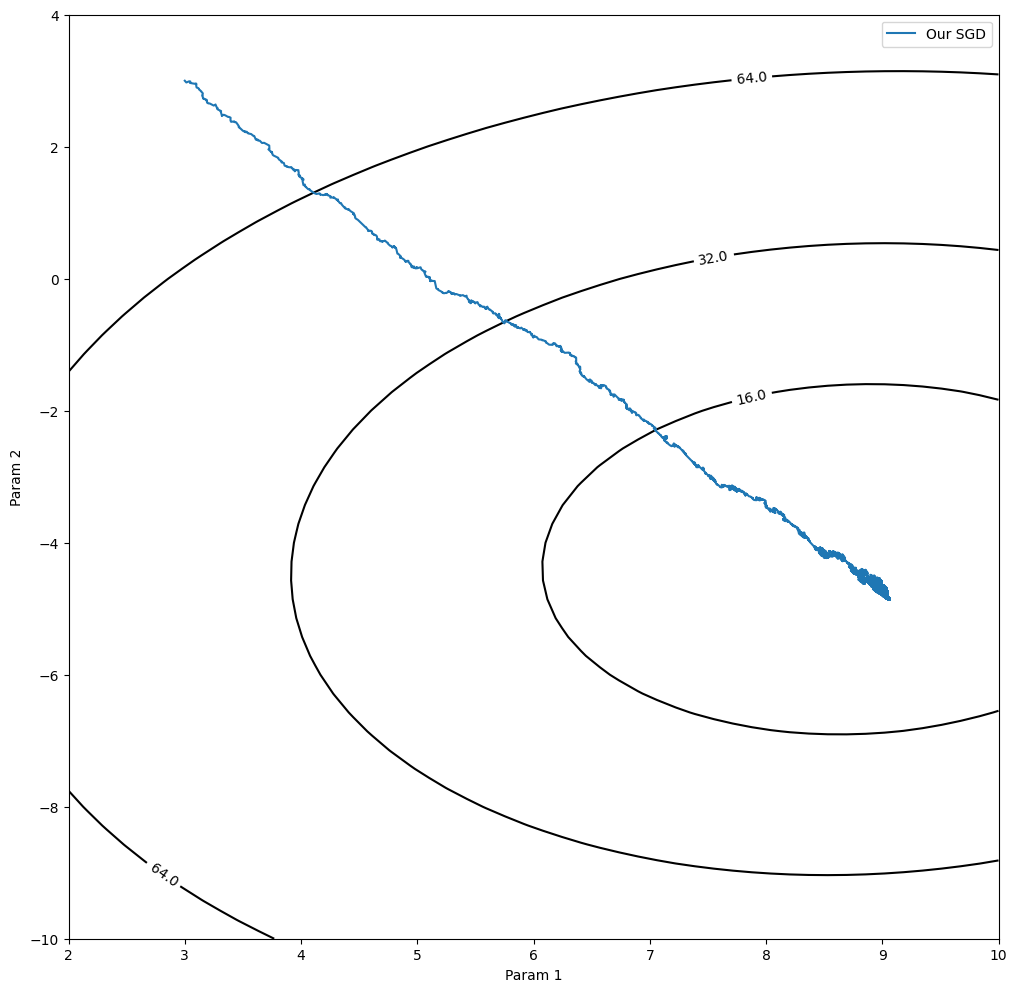

In [19]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_params[:,0], sgd_params[:,1], label='Our SGD')
ax.legend()
fig

In [20]:
sgd_params, sgd_losses = get_parameters_over_training(optim.SGD)

126.18503 [ 6.741375 -1.830486]
101.4407 [ 8.980536  -4.5915585]
101.43984 [ 8.980641  -4.5916743]
101.43984 [ 8.980641  -4.5916743]
101.43984 [ 8.980641  -4.5916743]


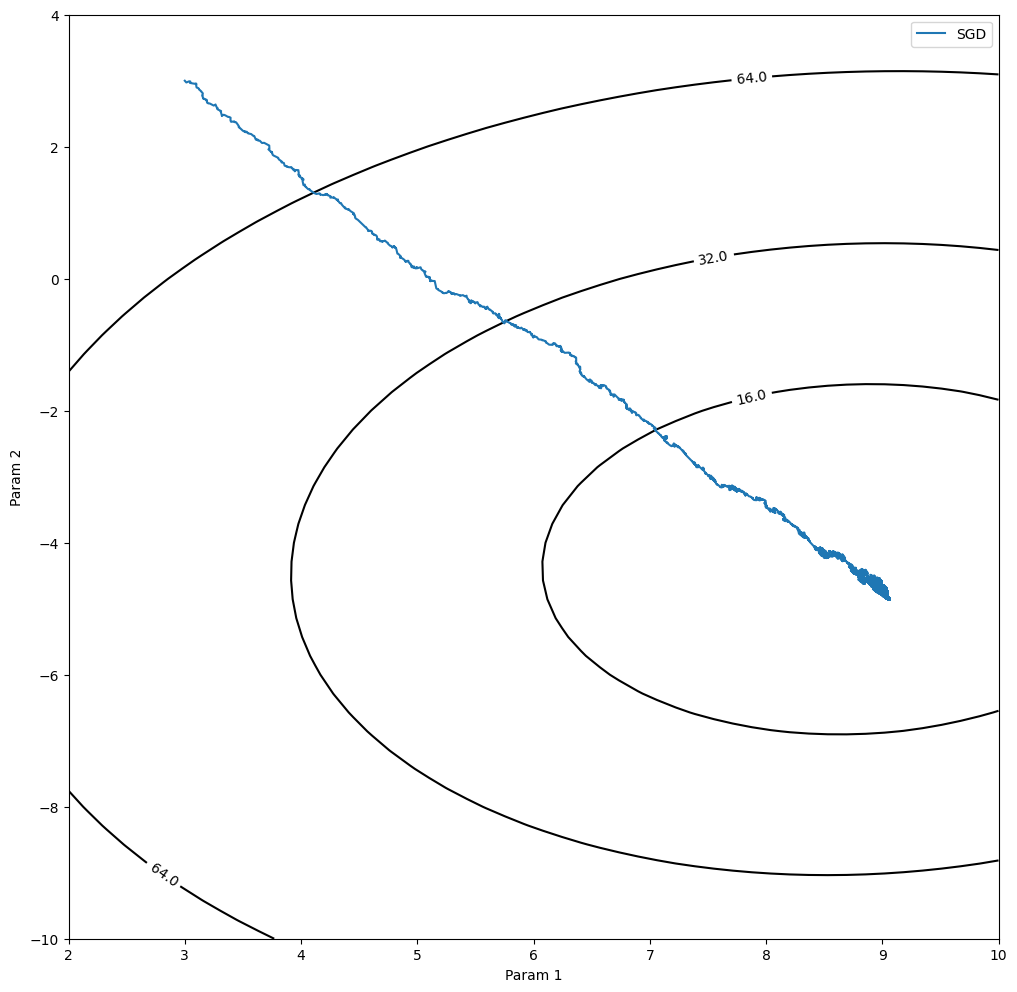

In [21]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_params[:,0], sgd_params[:,1], label='SGD')
ax.legend()
fig

In [22]:
class SGDWithMomentum(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9):
        defaults=dict(
            lr=lr,
            momentum=momentum
        )
        super().__init__(params, defaults=defaults)
        self.lr = lr
        self.momentum = momentum
        
    
    def step(self):
        # Iterate through all the parameters in the model
        for group in self.param_groups:
            for p in group['params']:
                # if the parameter doesn't ahve an "avg" attribute,
                # let's create one as a tensor of zeros.
                if not hasattr(p, 'avg'):
                    p.avg = torch.zeros_like(p.grad.data)
                # Let's update the moving average with the new update
                p.avg = self.momentum * p.avg - self.lr * p.grad
                # Finally, let's perform the parameter update step.
                p.data.add_(p.avg)

In [23]:
sgd_mom_params, sgd_mom_losses = get_parameters_over_training(SGDWithMomentum, opt_kwargs={'lr':1e-3, 'momentum':0.9})

101.28913 [ 9.17977   -4.4564066]
101.2884 [ 9.179886 -4.456493]
101.2884 [ 9.179886 -4.456493]
101.2884 [ 9.179886 -4.456493]
101.2884 [ 9.179886 -4.456493]


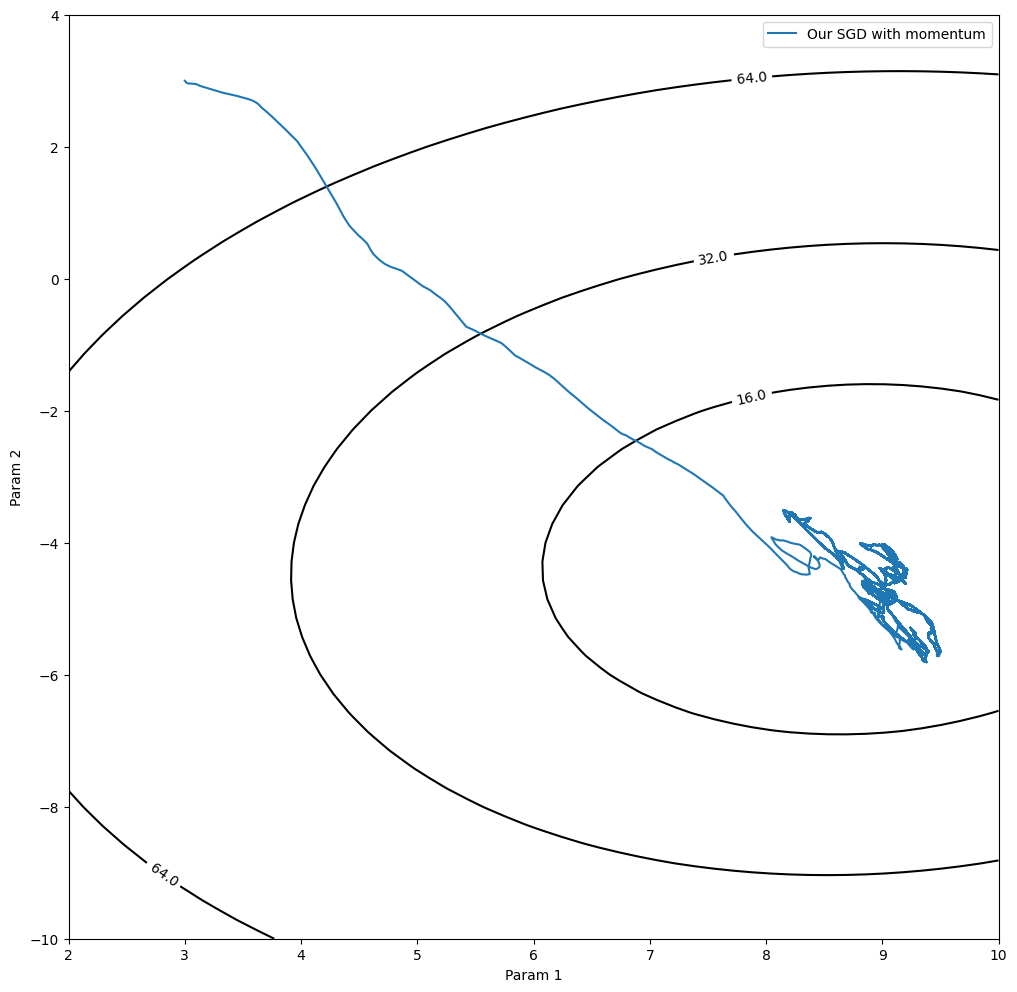

In [24]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_mom_params[:,0], sgd_mom_params[:,1], label='Our SGD with momentum')
ax.legend()
fig

In [25]:
sgd_small_mom_params, sgd_small_mom_losses = get_parameters_over_training(optim.SGD, opt_kwargs={'lr':1e-3, 'momentum':0.1})
sgd_med_mom_params, sgd_med_mom_losses = get_parameters_over_training(optim.SGD, opt_kwargs={'lr':1e-3, 'momentum':0.5})
sgd_large_mom_params, sgd_large_mom_losses = get_parameters_over_training(optim.SGD, opt_kwargs={'lr':1e-3, 'momentum':0.9})

123.11387 [ 6.9736576 -2.1187901]
101.47453 [ 8.981022  -4.5827165]
101.47423 [ 8.981067  -4.5827494]
101.47423 [ 8.981067  -4.5827494]
101.47423 [ 8.981067  -4.5827494]
109.47971 [ 8.155577 -3.534298]
101.682846 [ 8.990586 -4.522319]
101.682846 [ 8.990586 -4.522319]
101.682846 [ 8.990586 -4.522319]
101.682846 [ 8.990586 -4.522319]
101.28913 [ 9.17977   -4.4564066]
101.288414 [ 9.179886  -4.4564924]
101.288414 [ 9.179886  -4.4564924]
101.288414 [ 9.179886  -4.4564924]
101.288414 [ 9.179886  -4.4564924]


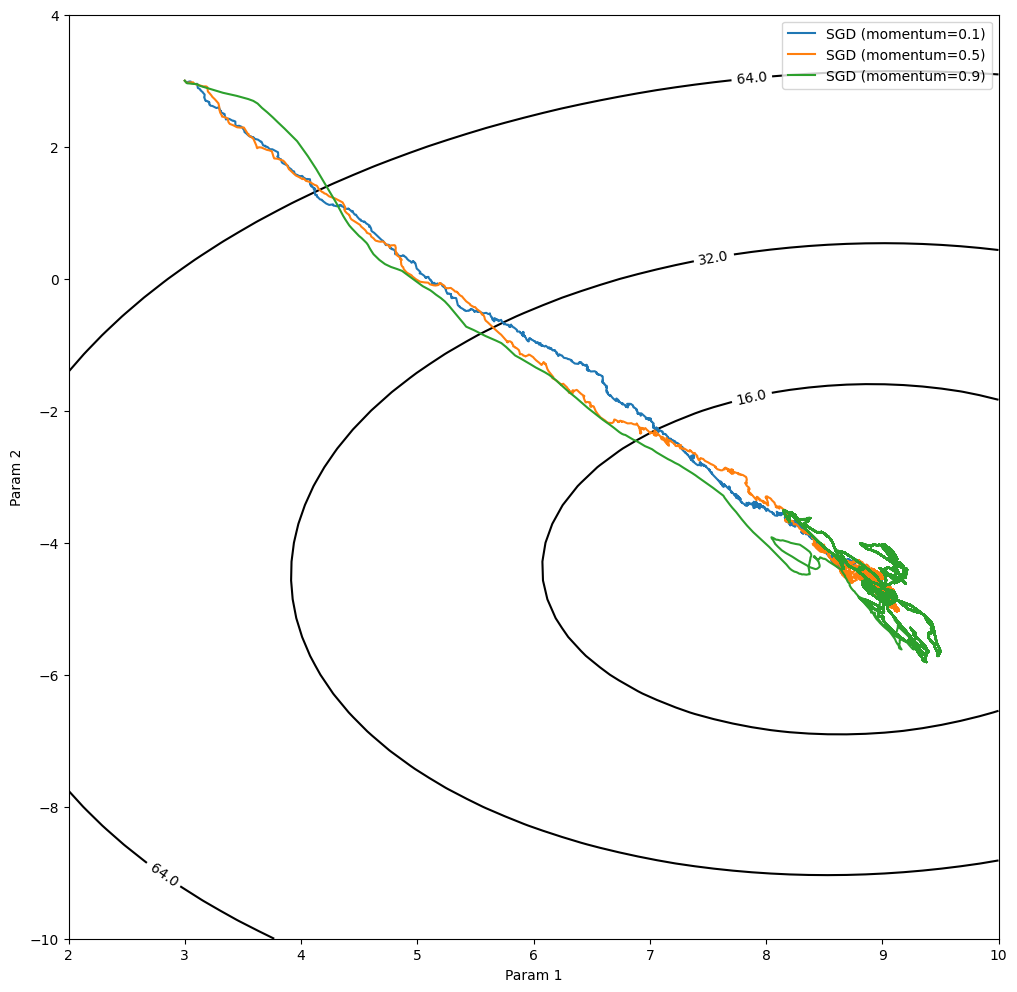

In [26]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_small_mom_params[:,0], sgd_small_mom_params[:,1], label='SGD (momentum=0.1)')
ax.plot(sgd_med_mom_params[:,0], sgd_med_mom_params[:,1], label='SGD (momentum=0.5)')
ax.plot(sgd_large_mom_params[:,0], sgd_large_mom_params[:,1], label='SGD (momentum=0.9)')
ax.legend()
fig

In [27]:
class RMSProp(optim.Optimizer):
    def __init__(self, params, lr, alpha=0.9, eps=1e-8):
        defaults=dict(
            lr=lr,
            alpha=alpha
        )
        super().__init__(params, defaults=defaults)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        
    
    def step(self):
        # Iterate through the parameters
        for group in self.param_groups:
            for p in group['params']:
                # If the parameter doesn't have a squared gradient attribute,
                # let's add one
                if not hasattr(p, 'sq_grad'):
                    p.sq_grad = torch.zeros_like(p.grad.data)
                # Update the squared gradient attribute
                p.sq_grad = self.alpha * p.sq_grad + (1 - self.alpha) * p.grad.data**2
                # Using the squared gradient attribute, calculate the update
                update = p.grad * self.lr / p.sq_grad.add(self.eps).sqrt()
                # Apply the update to the parameters
                p.data.sub_(update)

In [28]:
rms_params, rms_losses = get_parameters_over_training(RMSProp)

182.28267 [3.526561  2.5473964]
123.29434 [ 7.502562  -1.1868436]
107.62599 [ 8.716187  -3.3328927]
102.95541 [ 8.948022 -4.246998]
101.39 [ 8.990384  -4.5951285]


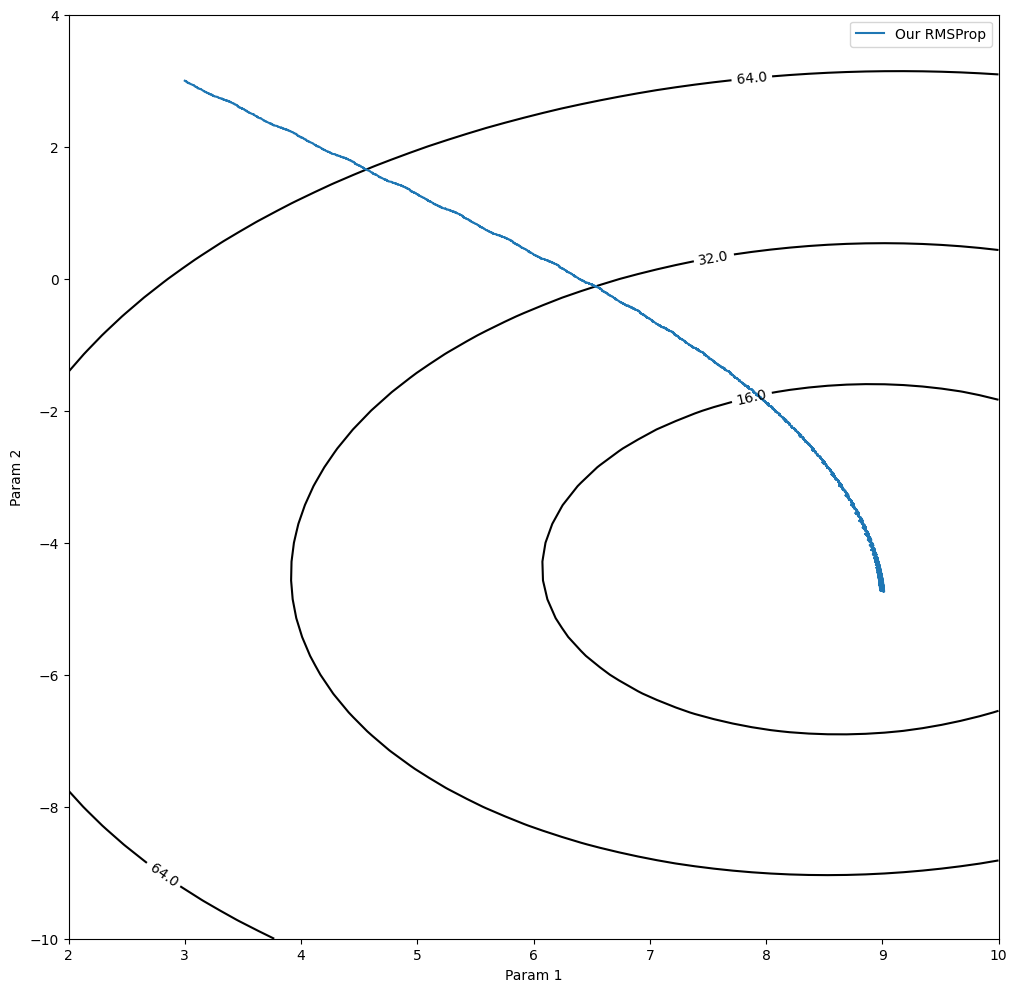

In [29]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(rms_params[:,0], rms_params[:,1], label='Our RMSProp')
ax.legend()
fig

In [30]:
rms_params, rms_losses = get_parameters_over_training(optim.RMSprop, opt_kwargs={'lr':1e-3})

180.93944 [3.5939188 2.4688413]
121.691216 [ 7.6337996 -1.360265 ]
106.95778 [ 8.772114  -3.4382076]
102.98169 [ 8.943472  -4.2447467]
101.744095 [ 8.968361  -4.5275173]


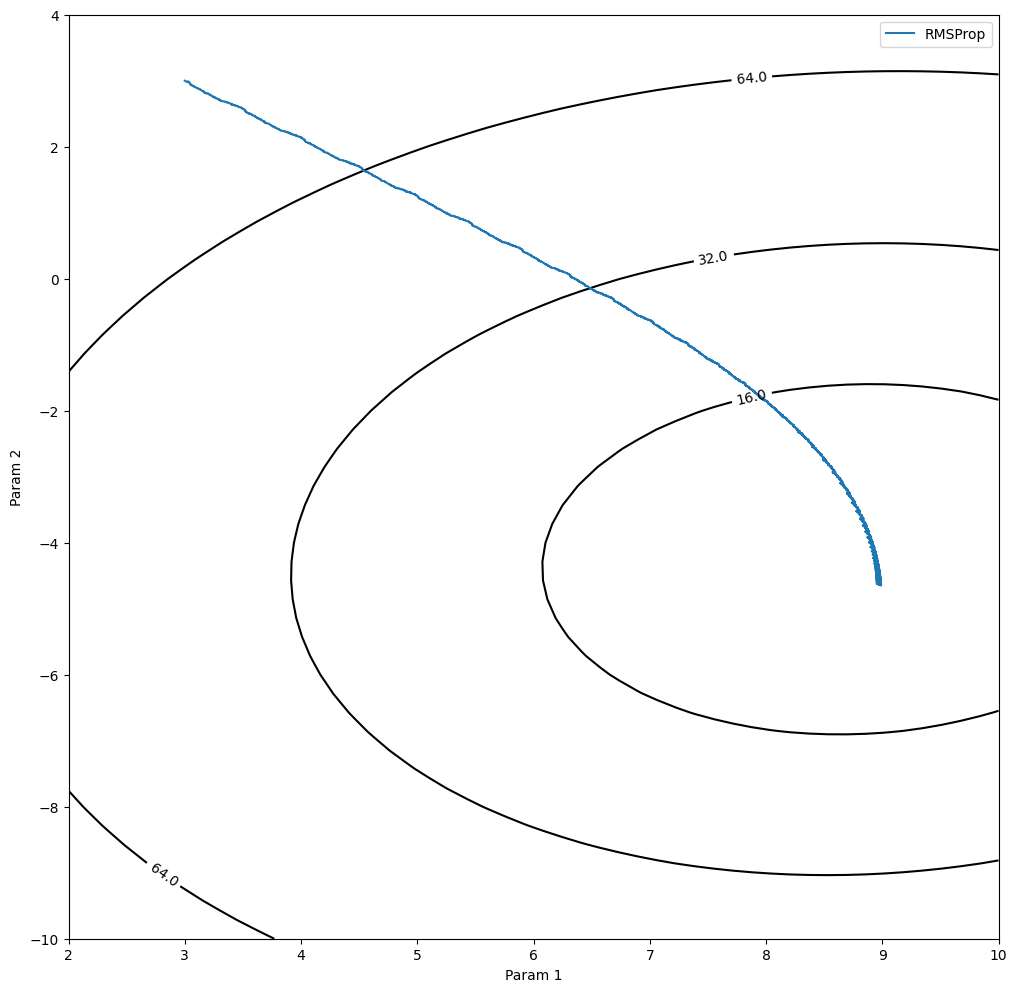

In [31]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
# ax.plot(sgd_params[:,0], sgd_params[:,1], label='SGD')
ax.plot(rms_params[:,0], rms_params[:,1], label='RMSProp')
ax.legend()
fig

In [32]:
class Adam(optim.Optimizer):
    def __init__(self, params, lr, grad_mom=0.9, rms_mom=0.99, eps=1e-8):
        defaults=dict(
            lr=lr,
            grad_mom=grad_mom,
            rms_mom=rms_mom,
            eps=eps
        )
        super().__init__(params, defaults=defaults)
        self.lr = lr
        self.grad_mom = grad_mom
        self.rms_mom = rms_mom
        self.eps = eps
        self.step_no = 0
        
    def step(self):
        # Iterate through the parameters
        for group in self.param_groups:
            for p in group['params']:
                # If the parameters dont' have records of the average or squared
                # average, let's add them
                if not hasattr(p, 'avg'):
                    p.avg = torch.zeros_like(p.grad.data)
                    p.sq_avg = torch.zeros_like(p.grad.data)
                # First, let's calculate the moving average update
                p.avg = self.grad_mom * p.avg + (1 - self.grad_mom) * p.grad.data
                ma_update = p.avg / (1 - self.grad_mom**self.step_no)
                
                # Next, let's calculate the RMS update
                p.sq_avg = self.rms_mom * p.sq_avg + (1 - self.rms_mom) * p.grad.data**2
                rms_update = p.sq_avg / (1 - self.rms_mom**self.step_no)
                
                # Finally, we'll combine the grad and sq grad updates
                # into the final update, then apply the update to our params.
                update = self.lr * p.avg / p.sq_avg.add(self.eps).sqrt()
                p.data.sub_(update)
                self.step_no += 1

In [33]:
adam_params, adam_losses = get_parameters_over_training(Adam)

181.39615 [3.5692384 2.4901829]
121.73929 [ 7.627818  -1.3579898]
106.9243 [ 8.775879  -3.4425704]
102.95944 [ 8.947907 -4.246113]
101.73531 [ 8.97271   -4.5256886]


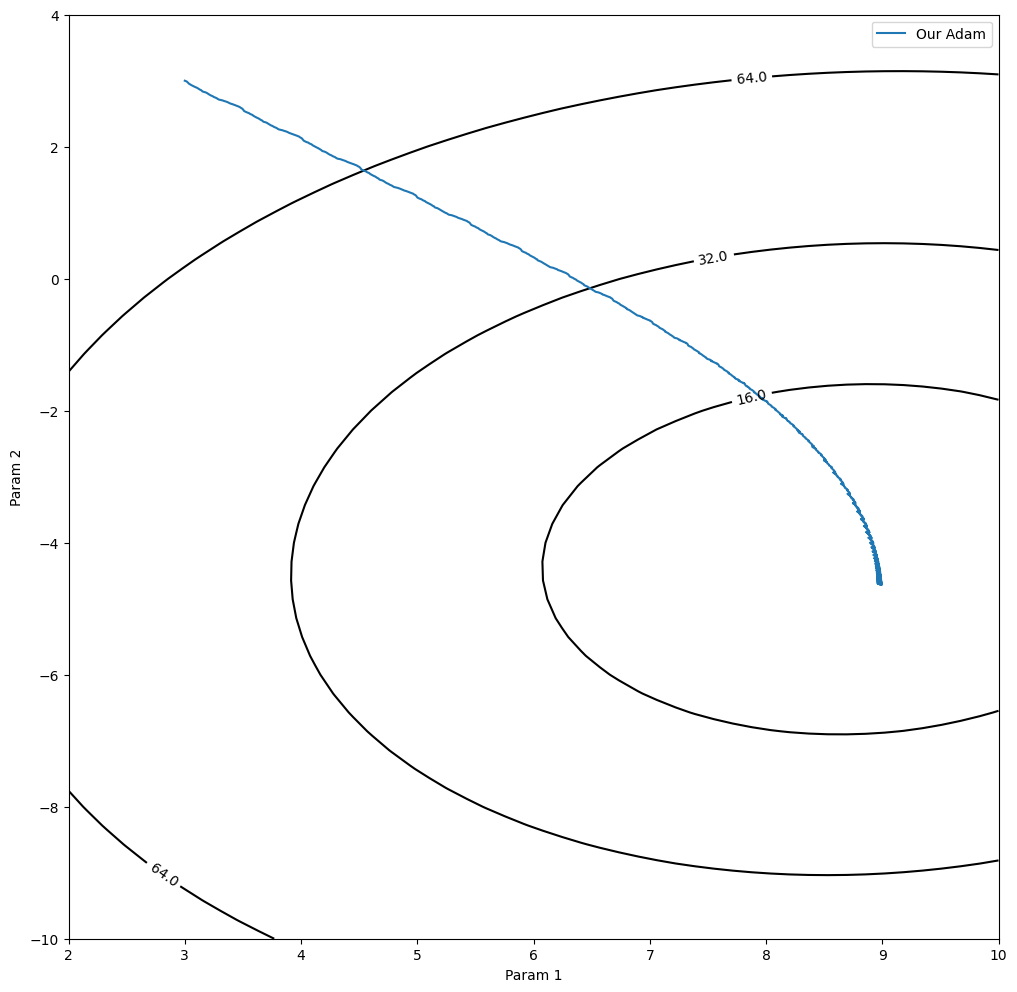

In [34]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(adam_params[:,0], adam_params[:,1], label='Our Adam')
ax.legend()
fig

In [35]:
adam_params, adam_losses = get_parameters_over_training(optim.Adam)

182.15486 [3.530745  2.5329747]
123.13364 [ 7.4849086 -1.2514868]
107.21376 [ 8.7590065 -3.389298 ]
103.012054 [ 8.950202 -4.231024]
101.74073 [ 8.97644   -4.5209174]


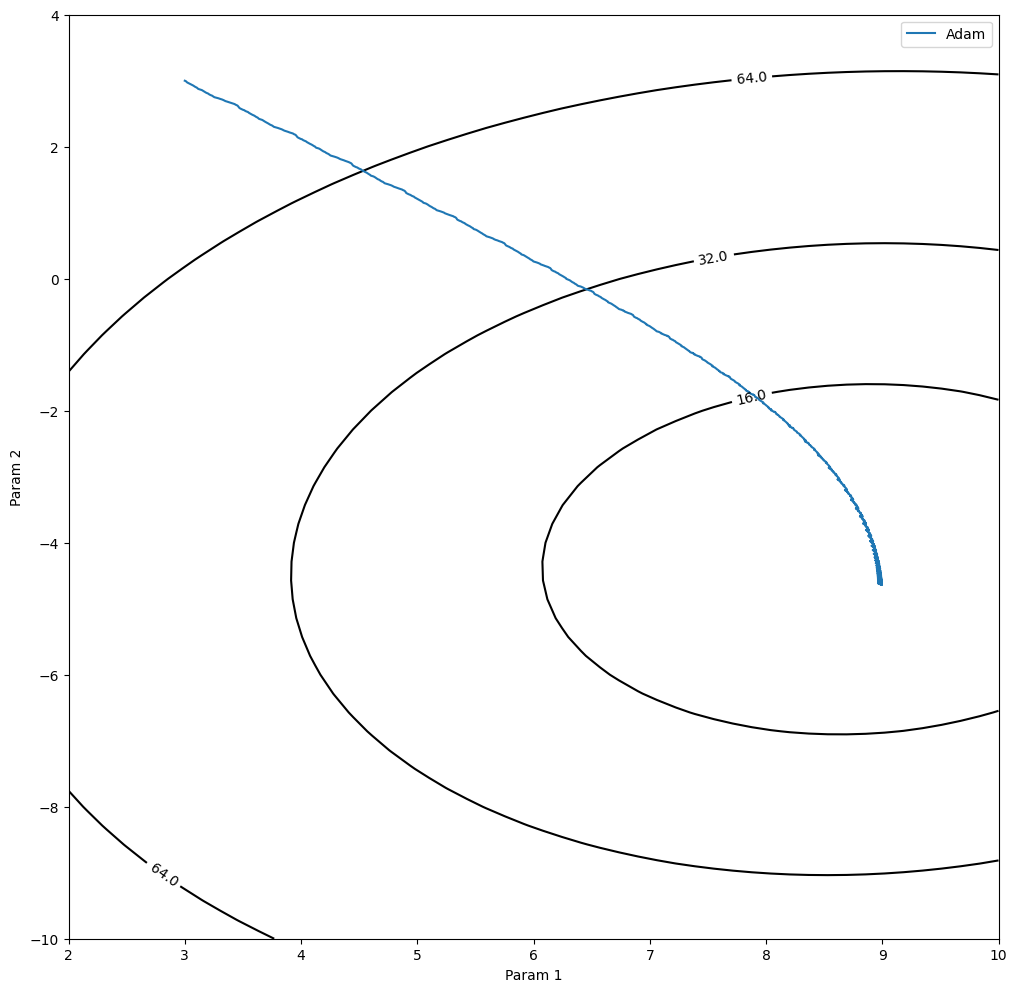

In [36]:
fig = loss_fig(True)
ax = fig.gca()
ax.plot(adam_params[:,0], adam_params[:,1], label='Adam')
ax.legend()
fig